In [73]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Demo") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()

In [78]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, count, lit
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType

df = spark.range(0, 1000 * 1000).withColumn('id', (col('id') / 10000).cast('integer')).withColumn('v', rand())
#df.cache()
df.count()

#df.show()

+---+--------------------+
| id|                   v|
+---+--------------------+
|  0|  0.6396597339694802|
|  0|  0.9397931714622013|
|  0|  0.6591600246397912|
|  0| 0.19376043136814602|
|  0| 0.48837864024237754|
|  0| 0.03328959471057635|
|  0|  0.9199406267596004|
|  0| 0.14130572250892426|
|  0|   0.619596330797797|
|  0| 0.18111075320458392|
|  0|     0.9189407080273|
|  0|   0.453446078408109|
|  0|  0.7492194974563935|
|  0|0.022970691407076194|
|  0|   0.197288877926302|
|  0|  0.4917213965416942|
|  0| 0.34604221937986046|
|  0| 0.16944020075076216|
|  0|  0.5082434678796076|
|  0| 0.15950979939781618|
+---+--------------------+
only showing top 20 rows



In [105]:
@udf('double')
def plus_one(v):
    return v + 1

plus_one_results = %timeit -o df.withColumn('v', plus_one(df.v)).agg(count(col('v')))

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

492 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
@pandas_udf("double", PandasUDFType.SCALAR)
def pandas_plus_one(v):
    return v + 1

pandas_plus_one_results = %timeit -o df.withColumn('v', pandas_plus_one(df.v)).agg(count(col('v')))

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+

+--------+
|count(v)|
+--------+
| 1000000|
+--------+



In [108]:
import pandas as pd
from scipy import stats

@udf('double')
def cdf(v):
    # stats.norm.cdf works on ints, lists, Pandas Series and NumPy arrays
    return float(stats.norm.cdf(v))

cdf_results = %timeit -o -q -n2 df.withColumn('cumulative_probability', cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+



In [128]:
import pandas as pd
from scipy import stats

# returnType=PandasUDFType.SCALAR is implied
@pandas_udf('double')
def pandas_cdf(v):
    return pd.Series(stats.norm.cdf(v))

pandas_cdf_results = %timeit -o df.withColumn('cumulative_probability', pandas_cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                      1000000|
+-----------------------------+

+-----------------------------+
|c

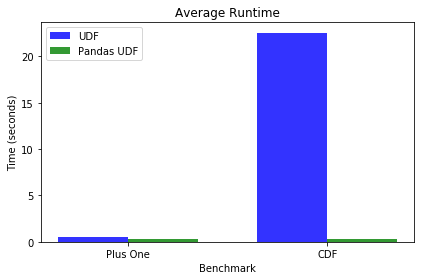

In [129]:
import matplotlib.pyplot as plt

n_groups = 2
udf_data = (plus_one_results.average, cdf_results.average)
pudf_data = (pandas_plus_one_results.average, pandas_cdf_results.average)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, udf_data, bar_width,
alpha=opacity,
color='b',
label='UDF')

rects2 = plt.bar(index + bar_width, pudf_data, bar_width,
alpha=opacity,
color='g',
label='Pandas UDF')

plt.xlabel('Benchmark')
plt.ylabel('Time (seconds)')
plt.title('Average Runtime')
plt.xticks(index + bar_width/2, ('Plus One', 'CDF'))
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Grouped Map
from pyspark.sql.functions import pandas_udf, PandasUDFType
df = spark.createDataFrame(
    [(1, 1.0, "apple"),
     (1, 2.0, "pear"),
     (2, 3.0, "orange"),
     (2, 5.0, "grape"),
     (2, 10.0, "peach")],
    ("id", "v", "fruit"))

@pandas_udf("id long, v double, norm double, fruit string", PandasUDFType.GROUPED_MAP)
def normalize(pdf):
    v = pdf.v
    return pdf.assign(norm=(v - v.mean()) / v.std())

df.groupby("id").apply(normalize).show()

+---+----+-------------------+------+
| id|   v|               norm| fruit|
+---+----+-------------------+------+
|  1| 1.0|-0.7071067811865475| apple|
|  1| 2.0| 0.7071067811865475|  pear|
|  2| 3.0|-0.8320502943378437|orange|
|  2| 5.0|-0.2773500981126146| grape|
|  2|10.0| 1.1094003924504583| peach|
+---+----+-------------------+------+



In [137]:
import databricks.koalas as ks
import numpy as np
from scipy import stats

kdf = df.to_koalas()

# def printer(s) -> np.int64:
# #    return s*2
#     return stats.norm.cdf(s)

# # Need a better benchmark!  Something that is like the other benchmarks.
# koalas_apply_results = %timeit -o kdf['id'].apply(printer)

kdf['newCol'] = kdf['v'] * kdf['id']
kdf.describe()

,id,v,newCol
count,1000000.000000,1.000000e+06,1000000.000000
mean,49.500000,4.997750e-01,24.758108
std,28.866084,2.886805e-01,21.965422
min,0.000000,2.745763e-07,0.000000
25%,24.000000,2.497870e-01,6.584296
50%,50.000000,4.997043e-01,18.438158
75%,74.000000,7.495540e-01,37.966721
max,99.000000,9.999996e-01,98.993360


In [138]:
# Back to a Spark DataFrame
sdf = kdf.to_spark()
sdf.show()

# Or other outputs:
#pdf = kdf.to_pandas()
#kdf.to_parquet('/file/path.parquet')

+---+--------------------+------+
| id|                   v|newCol|
+---+--------------------+------+
|  0|  0.6396597339694802|   0.0|
|  0|  0.9397931714622013|   0.0|
|  0|  0.6591600246397912|   0.0|
|  0| 0.19376043136814602|   0.0|
|  0| 0.48837864024237754|   0.0|
|  0| 0.03328959471057635|   0.0|
|  0|  0.9199406267596004|   0.0|
|  0| 0.14130572250892426|   0.0|
|  0|   0.619596330797797|   0.0|
|  0| 0.18111075320458392|   0.0|
|  0|     0.9189407080273|   0.0|
|  0|   0.453446078408109|   0.0|
|  0|  0.7492194974563935|   0.0|
|  0|0.022970691407076194|   0.0|
|  0|   0.197288877926302|   0.0|
|  0|  0.4917213965416942|   0.0|
|  0| 0.34604221937986046|   0.0|
|  0| 0.16944020075076216|   0.0|
|  0|  0.5082434678796076|   0.0|
|  0| 0.15950979939781618|   0.0|
+---+--------------------+------+
only showing top 20 rows

